<a href="https://colab.research.google.com/github/57saejin/git-training-1/blob/master/NASA_RUL_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3

In [ ]:
%matplotlib inline
#첫 번째 줄에서 %matplotlib inline 의 역할은 notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것 입니다.

import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
train_file = 'train_FD004.txt'
test_file = 'test_FD004.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv(train_file, sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv(test_file, sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv('RUL_FD004.txt', sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

print(train.shape)
train.head()

(61249, 26)


unit_nr  time_cycles  setting_1  setting_2  ...  s_18    s_19   s_20     s_21
0        1            1    42.0049     0.8400  ...  2212  100.00  10.62   6.3670
1        1            2    20.0020     0.7002  ...  2324  100.00  24.37  14.6552
2        1            3    42.0038     0.8409  ...  2212  100.00  10.48   6.4213
3        1            4    42.0000     0.8400  ...  2212  100.00  10.54   6.4176
4        1            5    25.0063     0.6207  ...  1915   84.93  14.03   8.6754

[5 rows x 26 columns]

In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  320
1        1            2  319
2        1            3  318
3        1            4  317
4        1            5  316

In [ ]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() 

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [ ]:
X_test

setting_1  setting_2  setting_3     s_1  ...  s_18    s_19   s_20     s_21
unit_nr                                           ...                              
1          25.0070     0.6214       60.0  462.54  ...  1915   84.93  14.41   8.6329
2          41.9989     0.8400      100.0  445.00  ...  2212  100.00  10.58   6.4325
3          42.0005     0.8401      100.0  445.00  ...  2212  100.00  10.61   6.3488
4          25.0018     0.6207       60.0  462.54  ...  1915   84.93  14.41   8.5696
5          25.0039     0.6200       60.0  462.54  ...  1915   84.93  14.19   8.6248
...            ...        ...        ...     ...  ...   ...     ...    ...      ...
244        20.0037     0.7000      100.0  491.19  ...  2324  100.00  24.42  14.5261
245        20.0066     0.7017      100.0  491.19  ...  2324  100.00  24.70  14.8356
246        19.9982     0.7008      100.0  491.19  ...  2324  100.00  24.70  14.7371
247        25.0024     0.6216       60.0  462.54  ...  1915   84.93  14.21   8.4721
248        35.0075     0.8402      100.0  449.44  ...  2223  100.00  14.72   8.8502

[248 rows x 24 columns]

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:60.2859955534359, R2:0.5491334954684775
test set RMSE:47.75764832868108, R2:0.23279090539968395


In [ ]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

In [ ]:
def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [ ]:
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

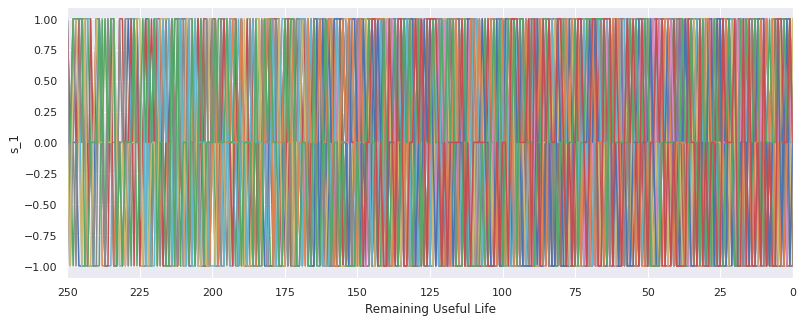

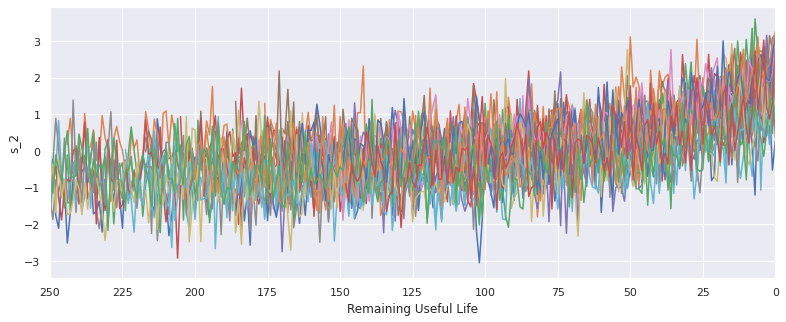

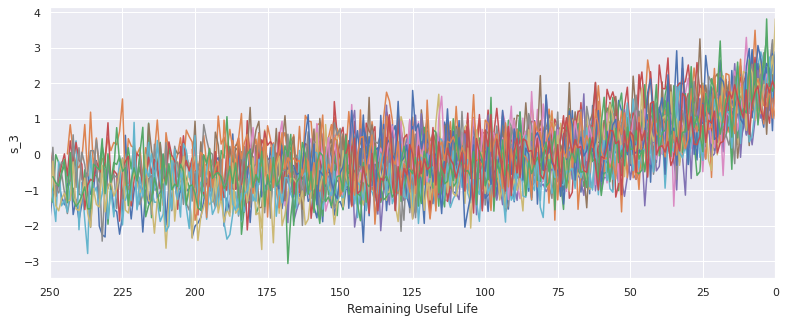

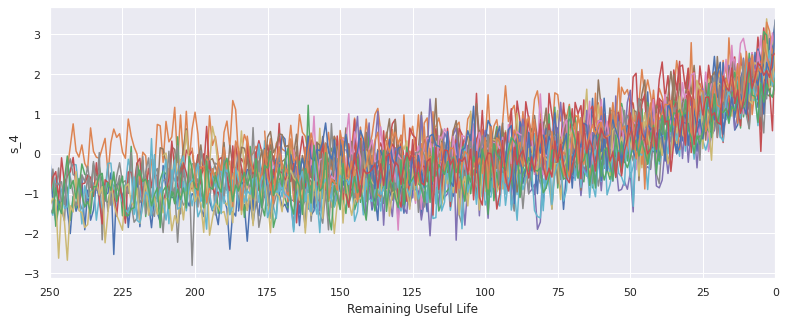

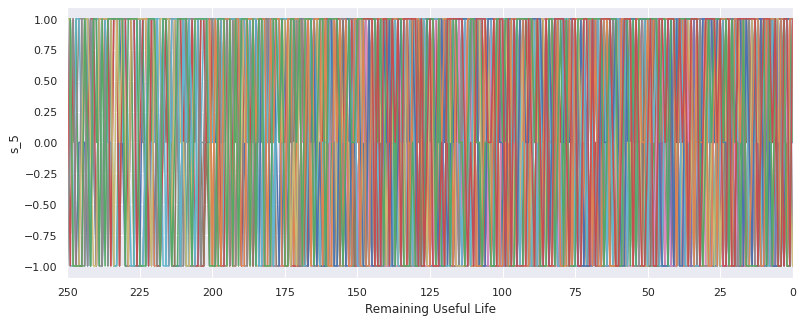

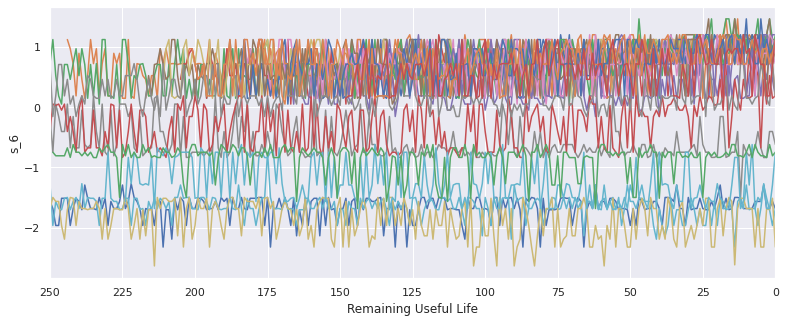

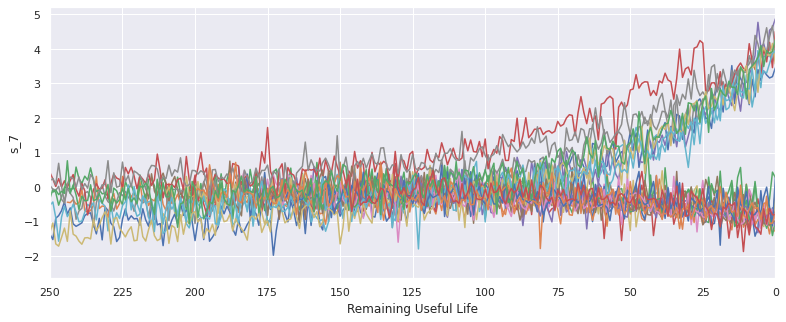

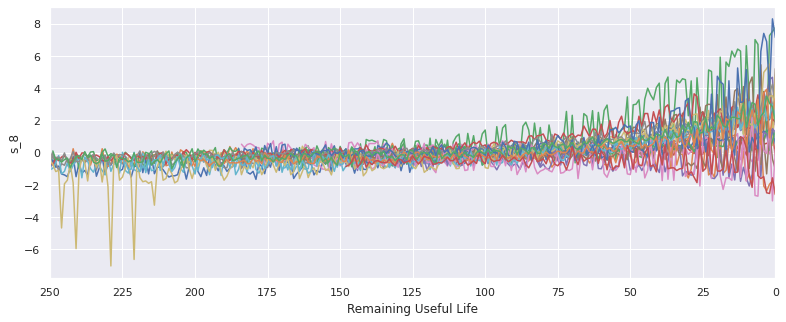

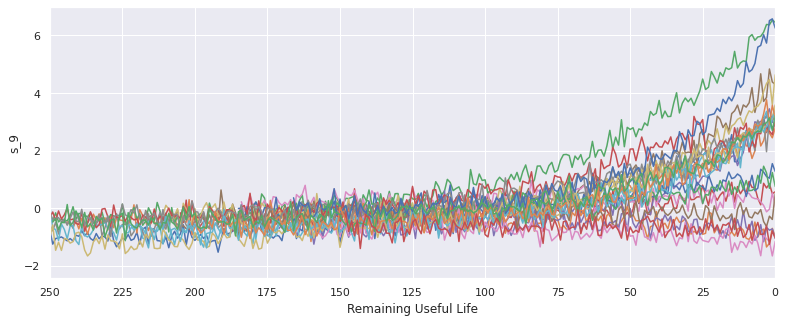

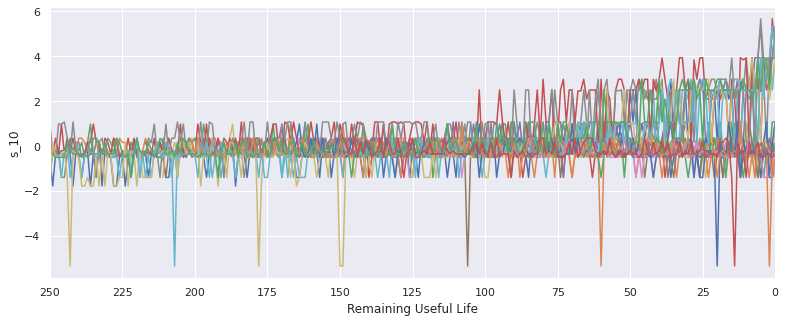

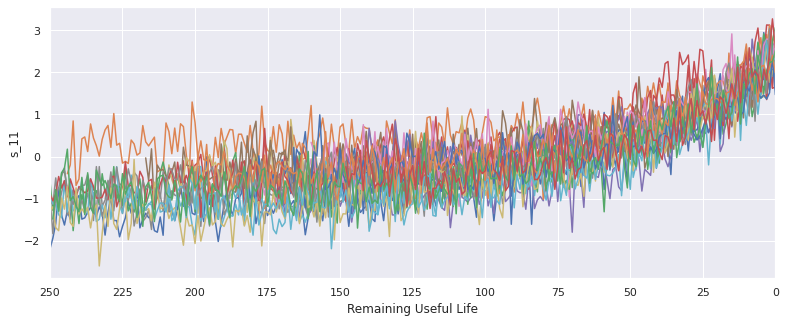

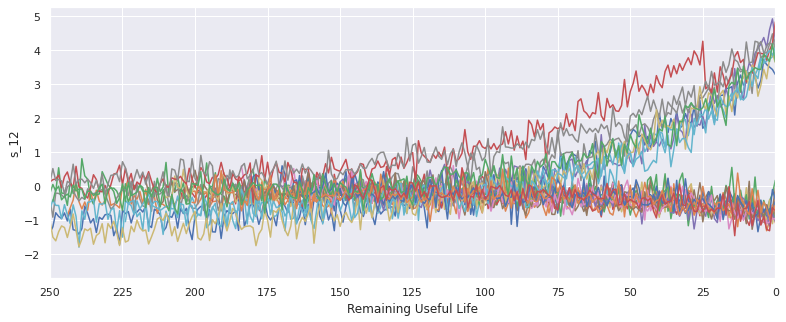

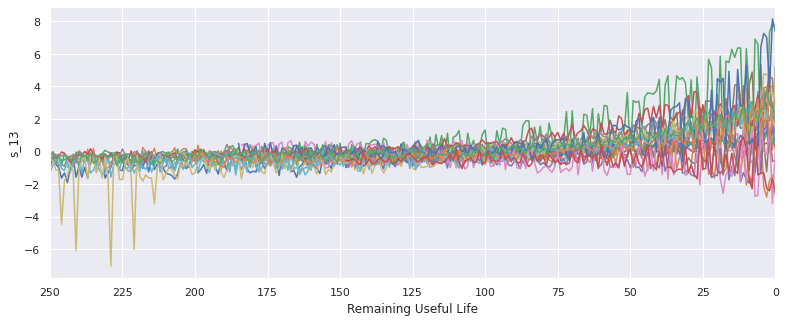

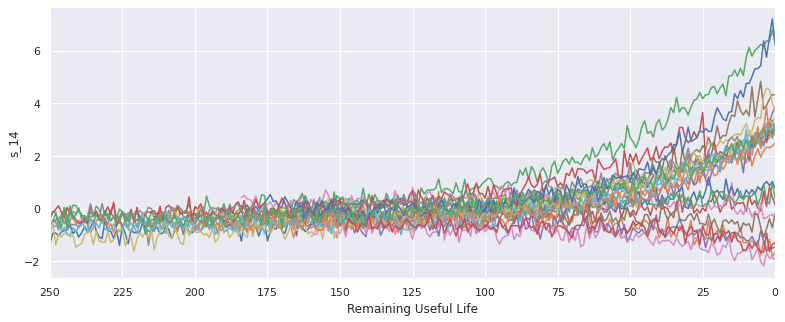

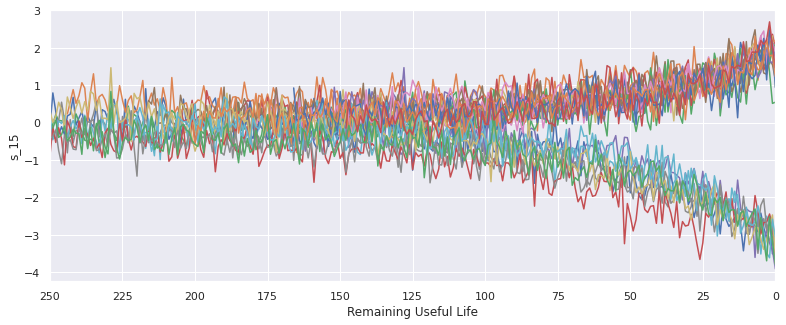

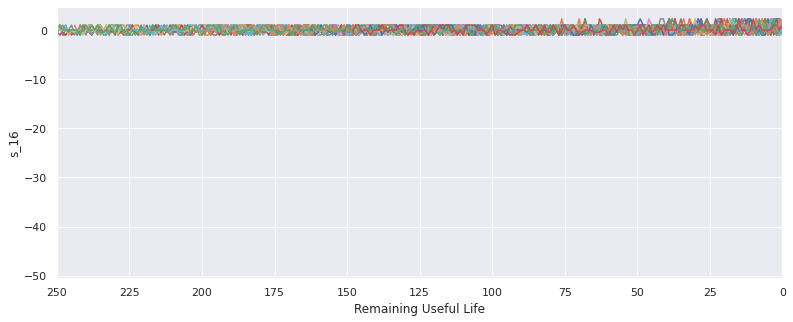

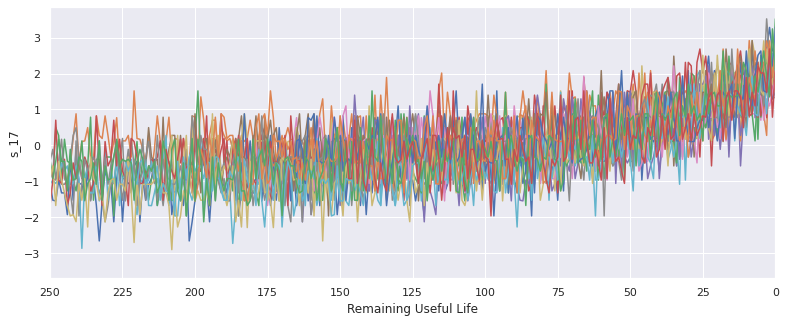

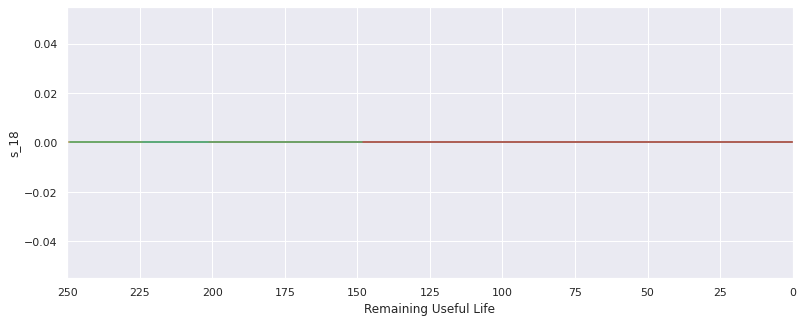

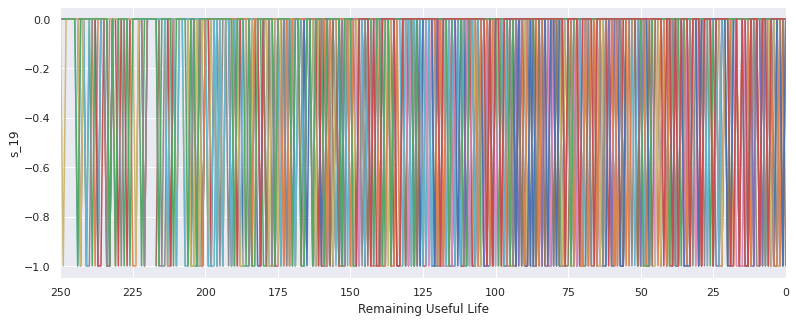

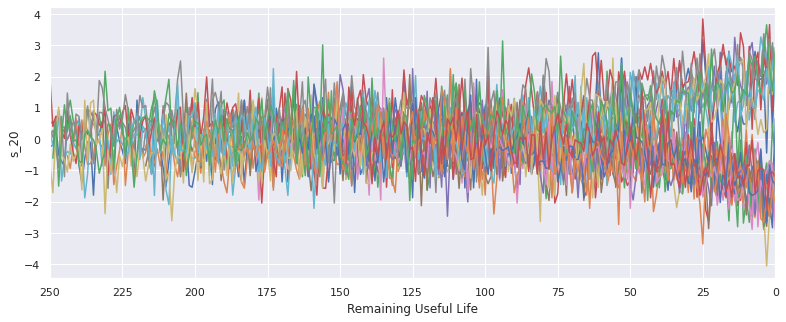

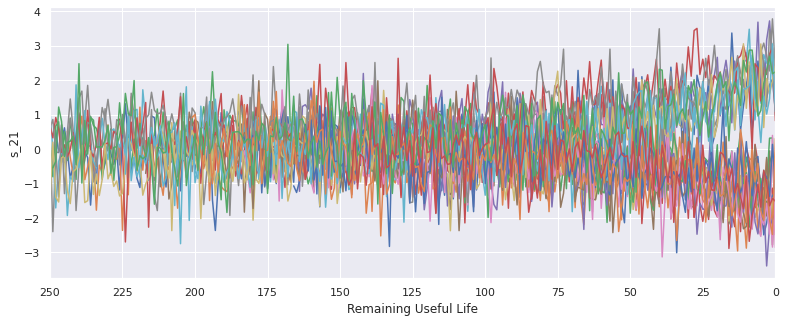

In [ ]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()
    
for sensor in sensor_names:
  plot_signal(X_train_condition_scaled, sensor)

In [ ]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [ ]:
drop_sensors

['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

In [ ]:
sensor_names

['s_1',
 's_2',
 's_3',
 's_4',
 's_5',
 's_6',
 's_7',
 's_8',
 's_9',
 's_10',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_16',
 's_17',
 's_18',
 's_19',
 's_20',
 's_21']

Exponential Smoothing 
 Xt = a*Xt + (1 - a)*~Xt -1

In [ ]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [ ]:

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

In [ ]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

gen = gen_train_data(example_df[example_df['unit_nr']==1], sequence_length=4, columns=['X'])
list(gen)

In [ ]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

data_array = gen_data_wrapper(example_df, sequence_length=4, columns=['X'])
data_array  

In [ ]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

label = gen_labels(example_df[example_df['unit_nr']==1], sequence_length=4, label=['y'])
label    

In [ ]:
label_array = gen_label_wrapper(example_df, sequence_length=4, label=['y'])
label_array

In [ ]:

# padding example
a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length
b = np.full(shape=(2,3), fill_value=0.)  # available sequence length

idx = a.shape[0] - b.shape[0]  # equals to 3

a[idx:,:] = b
a

In [ ]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

gen = (list(gen_test_data(example_df[example_df['unit_nr']==unit_nr], sequence_length=6, columns=['X'], mask_value=-99.))
           for unit_nr in example_df['unit_nr'].unique())
next(gen)

In [ ]:
sequence_length = 20
train['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

TypeError: ignored

In [ ]:

model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.h5')

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=5,
                   batch_size=32)

In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:

# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

In [ ]:

remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 
       's_11', 's_12', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [ ]:
# returns:
# train set RMSE:17.098350524902344, R2:0.8279650412665183
# test set RMSE:29.36311002353286, R2:0.709977307051393

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('fewer_sensors_lstm_weights.h5')

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=20,
                   batch_size=32)

In [ ]:
# I know lower alpha's perform better, so we can ditch a few high ones to reduce the search space
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
epoch_list = list(np.arange(5,20+1,5))
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
dropouts = list(np.arange(1,5)/10)  

# again, earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'sigmoid']
batch_size_list = [32, 64, 128, 256]
sensor_list = [['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'],
               ['s_2', 's_3', 's_4', 's_7', 's_11', 's_12', 's_15', 's_17', 's_20', 's_21']]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                          len(sensor_list)])
tuning_options

In [ ]:
def prep_data(train, test, drop_sensors, remaining_sensors, alpha):
    X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)
    
    return X_train_interim, X_test_interim

In [ ]:

# input_shape = (sequence_length, train_array.shape[2])
def create_model(input_shape, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=input_shape))
    if len(nodes_per_layer) <= 1:
        model.add(LSTM(nodes_per_layer[0], activation=activation))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(nodes_per_layer[1], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [ ]:
ITERATIONS = 60

results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', # bigger std means less robust
                                'epochs', 'nodes', 'dropout', 
                                'activation', 'batch_size', 
                                'sequence_length', 'sensor_length'])  

weights_file = 'lstm_hyper_parameter_weights.h5'


for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)
    
    mse = []
    
    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    sequence_length = random.sample(sequence_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    remaining_sensors = random.sample(sensor_list, 1)[0]
    drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
    
    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)
    
    # create train-val split
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
        train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
        train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
        train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
        
        val_unit = X_train_interim['unit_nr'].unique()[val_unit]
        val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
        val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)
        
        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration
        
        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        mse.append(history.history['val_loss'][-1])
    
    # append results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
         'sensor_length':len(remaining_sensors)}
    results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)

In [ ]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [ ]:

alpha = 0.1
sequence_length = 30
nodes_per_layer = [256]
dropout = 0.1
activation = 'sigmoid'
weights_file = 'fd004_model_weights.m5'
epochs = 15  
batch_size = 128

# prep data
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

input_shape = (sequence_length, len(remaining_sensors))
final_model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.load_weights(weights_file)

final_model.fit(train_array, label_array,
                epochs=epochs,
                batch_size=batch_size)

In [ ]:

# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)